# Phase 3: Time Series Modeling Forecasting

In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.11.0


In [3]:
# IPython
from IPython.display import IFrame

- Time series decomposition

    - Level
    - Trend
    - Seasonality
    - Noise
- Stationarity
    - AC and PAC plots
    - Rolling mean and std
    - Dickey-Fuller test
- Making our time series stationary
    - Difference transform
    - Log scale
    - Smoothing
    - Moving average

Time series:

- time_series_covid19_confirmed_US.csv
- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_US.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_recovered_global.csv

cross-section data:

- csse_covid_19_daily_reports
- csse_covid_19_daily_reports_us

In [4]:
from getdata import GET_csse_covid_19_daily_reports,GET_csse_covid_19_time_series,GET_shanghai_data

# get data
latest_data_global,prev_data_global,latest_data_us,prev_data_us = GET_csse_covid_19_daily_reports()
ts_confirmed_us,ts_confirmed_global,ts_deaths_us,ts_deaths_global,ts_recovered_global = GET_csse_covid_19_time_series()
ts_shanghai_covid = GET_shanghai_data(plot=True)  # 这里包含近10天的上海无症状新增趋势！

正在读取【横截面】数据......
读取完毕
正在读取【时间序列】数据......
读取完毕
正在获取并处理【上海】数据（数据来自上海卫健委）......


HTTPError: HTTP Error 403: Forbidden

In [8]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [9]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [10]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [11]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')

In [12]:
ts_confirmed_CHINA_incre.head()

,Macau,Anhui,Shanghai,Liaoning,Ningxia,Qinghai,Shaanxi,Shandong,Shanxi,Beijing,...,Heilongjiang,Hebei,Hainan,Guizhou,Guangxi,Guangdong,Gansu,Fujian,Chongqing,Zhejiang
2020-01-22,1,1,9,2,1,0,0,2,1,14,...,0,1,4,1,2,26,0,1,6,10
2020-01-23,1,8,7,1,0,0,3,4,0,8,...,2,0,1,2,3,6,2,4,3,17
2020-01-24,0,6,4,1,1,0,2,9,0,14,...,2,1,3,0,18,21,0,5,18,16
2020-01-25,0,24,13,13,1,1,10,12,5,5,...,5,6,11,1,0,25,2,8,30,19
2020-01-26,3,21,7,4,1,0,7,19,3,27,...,6,5,3,1,13,33,3,17,18,42


In [13]:
ts_confirmed_CHINA_incre.describe().T.sort_values('max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Hong Kong,1106.0,2600.457505,7473.332038,-23.0,4.0,19.0,1497.25,76991.0
Hubei,1106.0,65.217902,565.925522,-1.0,0.0,0.0,0.00,14840.0
Shanghai,1106.0,60.614828,352.288942,-589.0,2.0,5.0,10.00,5489.0
Jilin,1106.0,36.857143,259.313391,-1.0,0.0,0.0,0.00,4222.0
Zhejiang,1106.0,10.712477,129.822700,0.0,0.0,0.0,2.00,4220.0
Guangdong,1106.0,93.352622,380.776951,0.0,1.0,4.0,14.00,3508.0
Beijing,1106.0,36.866184,176.107716,-1.0,0.0,1.0,6.00,2360.0
Guangxi,1106.0,12.089512,122.957993,0.0,0.0,0.0,2.00,2046.0
Hainan,1106.0,9.478300,74.699506,0.0,0.0,0.0,0.00,1683.0


In [16]:
# pip install my-covid-report==1.8
from covid_report import getdata,data_processing,covid_visualization

In [17]:
covid_visualization.Decompose_CHINA(
    ts_confirmed_CHINA_incre,
    latest_data_CHINA,
    prev_data_CHINA,
    start='2022-03-15',
    ma = [3,7],
    method = 'New case',             
    specify = 'Shanghai',         
    verbose = 1,
    kind = 'Confirmed'
)

国家：中国
最新更新时间：2023-02-01 04:20:54
----------------------------------------TOTAL-----------------------------------------
截至目前【中国】累计确诊：3381681 | 新增确诊：1
截至目前【中国】累计死亡：18726 | 新增死亡：0
截至目前【Shanghai】累计确诊：67040 | 新增确诊：0
截至目前【Shanghai】累计死亡：595 | 新增死亡：0
----------------------------------------DETAIL----------------------------------------
蓝色为确诊数
红色为死亡数
--------------------------------------------------------------------------------------


UnboundLocalError: local variable 'data' referenced before assignment

- Automatic time series decomposition

Statsmodel python 库提供了一个函数`seasonal_compose()`来自动分解时间序列，需要指定模型是加法还是乘法。

In [20]:
ts_shanghai_confirmed = ts_shanghai_covid['New local confirmed cases']
ts_shanghai_asymptomatic = ts_shanghai_covid['New local asymptomatic']

NameError: name 'ts_shanghai_covid' is not defined

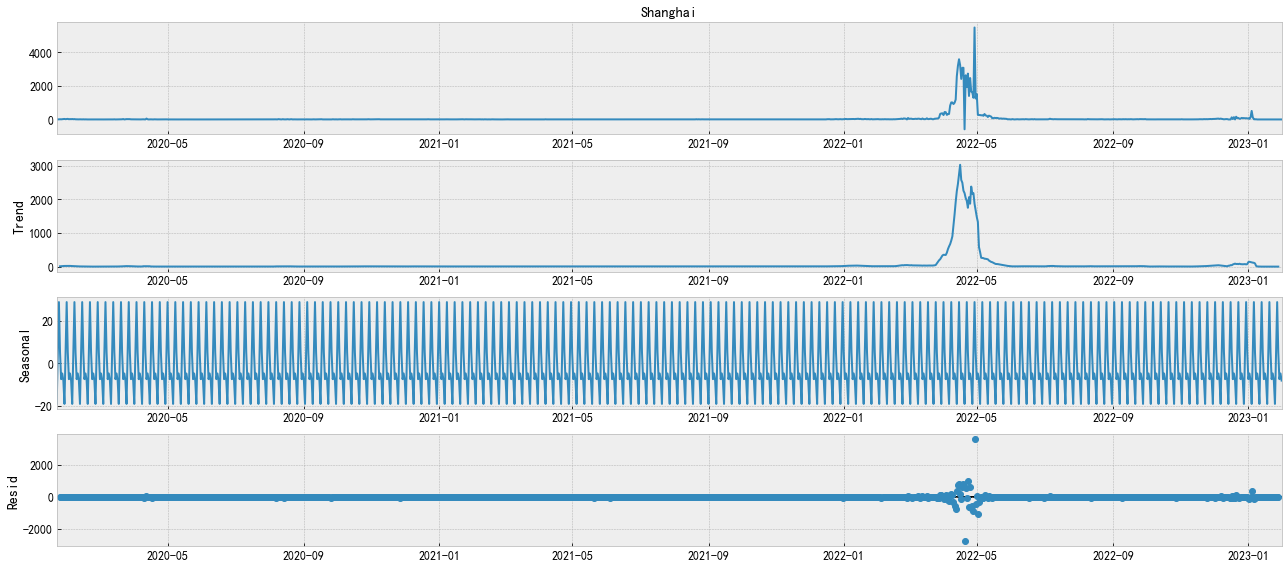

In [21]:
# 上海自2020年开始
series_2020 = ts_confirmed_CHINA_incre['Shanghai']
result = seasonal_decompose(series_2020, model='additive')
result.plot()
plt.show()

In [22]:
ts_confirmed_CHINA_incre['Shanghai']

2020-01-22     9
2020-01-23     7
2020-01-24     4
2020-01-25    13
2020-01-26     7
              ..
2023-01-27     0
2023-01-28     0
2023-01-29     0
2023-01-30     0
2023-01-31     0
Name: Shanghai, Length: 1106, dtype: int64

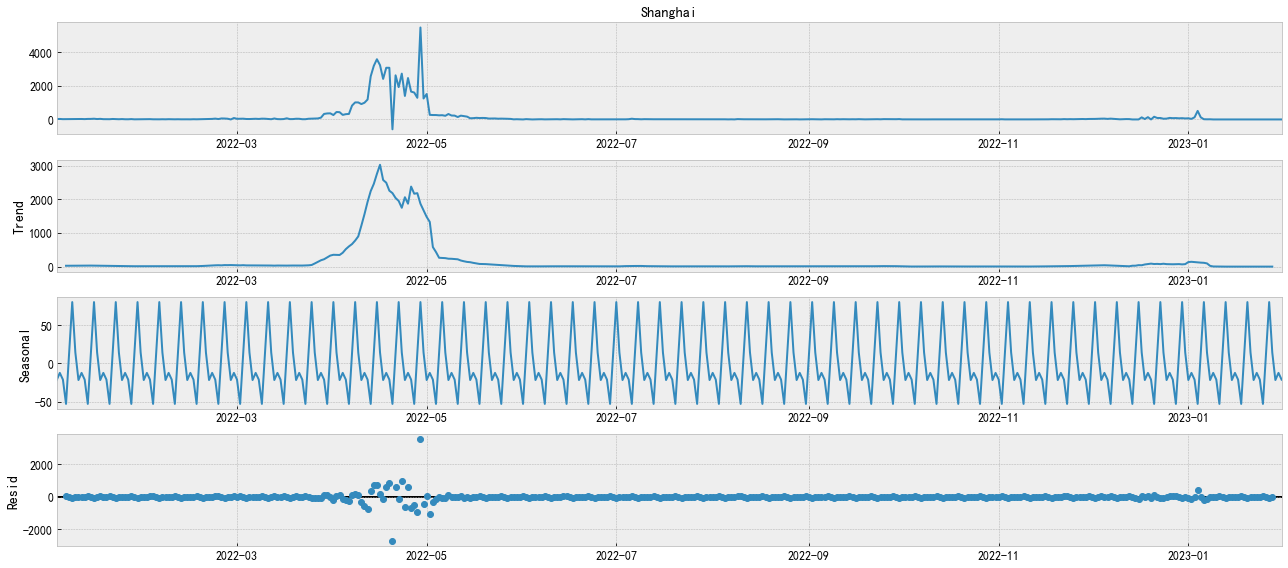

In [23]:
# 上海自2022年开始
series_2022 = ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>'2022-01-01']
result = seasonal_decompose(series_2022, model='additive')
result.plot()
plt.show() 

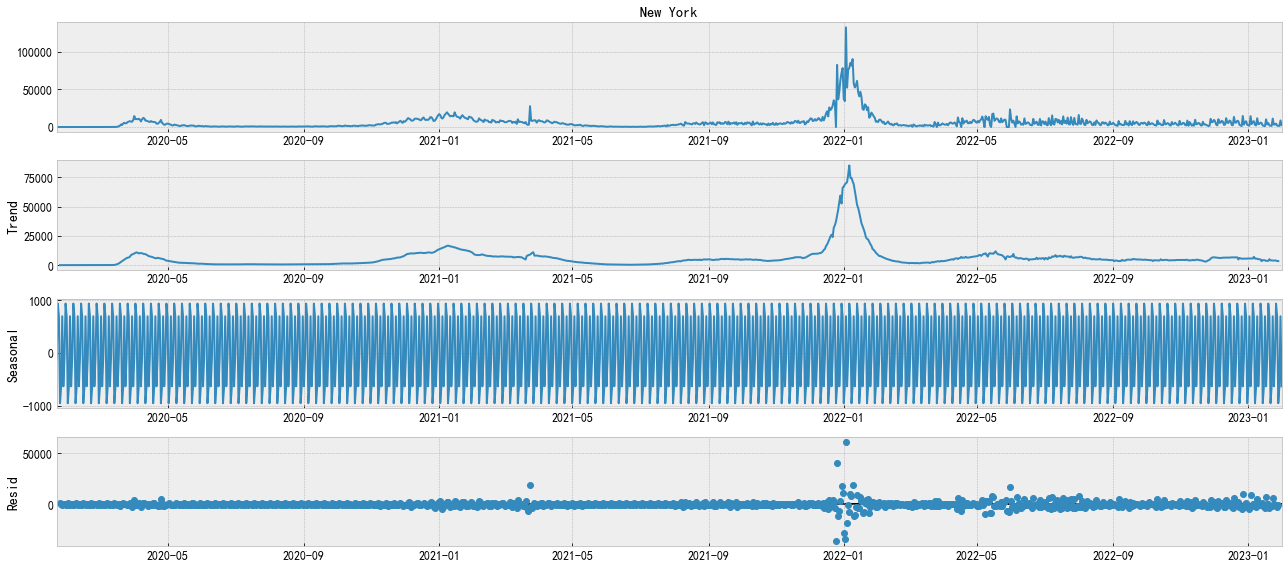

In [25]:
# NYC
nyc_series = ts_confirmed_US_incre['New York']
nyc_result = seasonal_decompose(nyc_series, model='additive')
nyc_result.plot()
plt.show() 

#### level

level可以理解为 the mean of the series，在我们去除trend、seasonality和noise之后，剩下的就是level，也是我们真正要预测的东西，脱下一层层的外衣，要去预测的其实就是the mean of the series。

#### Trend

trend有一个长期的轨迹趋势，可以是正向或负向。

从最基本的折线图就可以看出是否存在趋势了，那么再介绍一些检测序列是否有trend的方法：

- Automatic decomposing
- Moving average
- linear regression

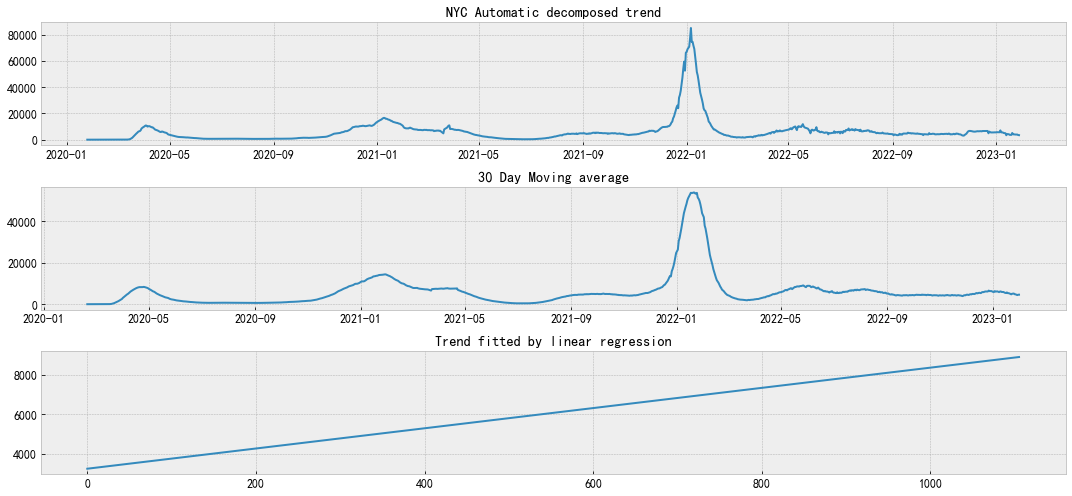

In [26]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(nyc_result.trend)
pm_ax.set_title("NYC Automatic decomposed trend")
 
mm = nyc_series.rolling(30).mean()
mv_ax.plot(mm)
mv_ax.set_title("30 Day Moving average")


X = [i for i in range(0, len(nyc_series))]
X = np.reshape(X, (len(X), 1))
y = nyc_series
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

可以看出纽约的新增确诊趋势不清晰，没有一个明确的线性关系。好像里面包含着不少的seasonality和noise。

#### Seasonality

当由于季节性因素在定期间隔之间观察到明显的重复模式时，就会观察到季节性。这可能是因为一年中的月份、月份中的某一天、工作日甚至一天中的时间。比如冰激凌的销量（冬天总是低，夏天总是高）。

一般，我们在长序列中发现seasonality不是很清楚的时候，一般会拆解为更小的序列，再去比较各part的seasonality。

Text(0, 0.5, '2022')

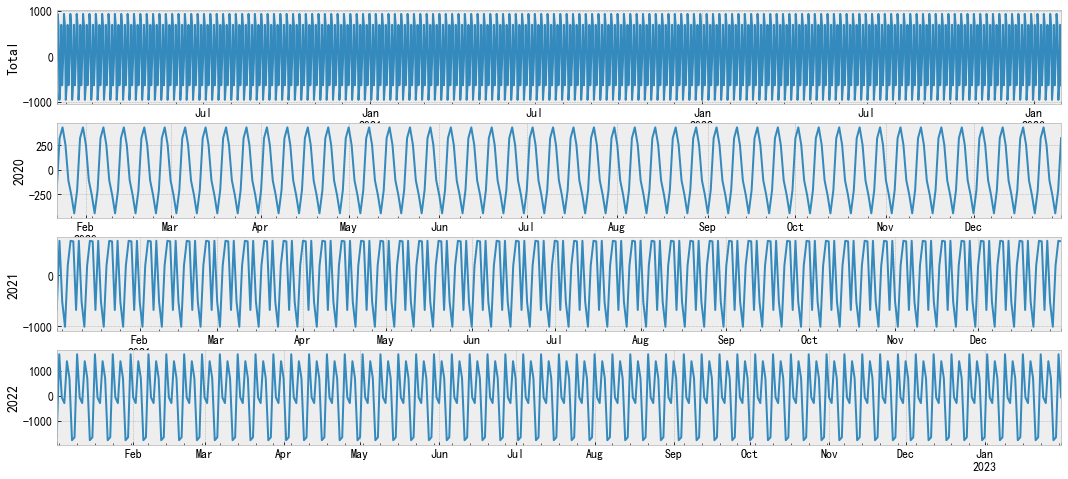

In [27]:
plt.subplot(411)
nyc_series = ts_confirmed_US_incre['New York']
nyc_result = seasonal_decompose(nyc_series, model='additive')
nyc_result.seasonal.plot()
plt.ylabel('Total')
plt.subplot(412)
nyc_series_2020 = ts_confirmed_US_incre['New York'][ts_confirmed_US_incre.index<'2021']
nyc_result_2020 = seasonal_decompose(nyc_series_2020, model='additive')
nyc_result_2020.seasonal.plot()
plt.ylabel('2020')
plt.subplot(413)
nyc_series_2021 = ts_confirmed_US_incre['New York'][(ts_confirmed_US_incre.index>'2021') &(ts_confirmed_US_incre.index<'2022')]
nyc_result_2021 = seasonal_decompose(nyc_series_2021, model='additive')
nyc_result_2021.seasonal.plot()
plt.ylabel('2021')
plt.subplot(414)
nyc_series_2022 = ts_confirmed_US_incre['New York'][ts_confirmed_US_incre.index>'2022']
nyc_result_2022 = seasonal_decompose(nyc_series_2022, model='additive')
nyc_result_2022.seasonal.plot()
plt.ylabel('2022')

可以看出每个月有4个spike，就是高点的意思。但是2021、2022年貌似更频繁一些，一个月有8个spike。

#### Noise

这里的噪声，可以理解为白噪声，也就是完全的随机。

如果时序数据有白噪声，说明我们不能做时序的预测。

如何检测？

- 查看分布，是否像高斯分布，均值为0，方差稳定
- ACF
- mean是否随时间变化

Text(0.5, 1.0, 'Mean over time')

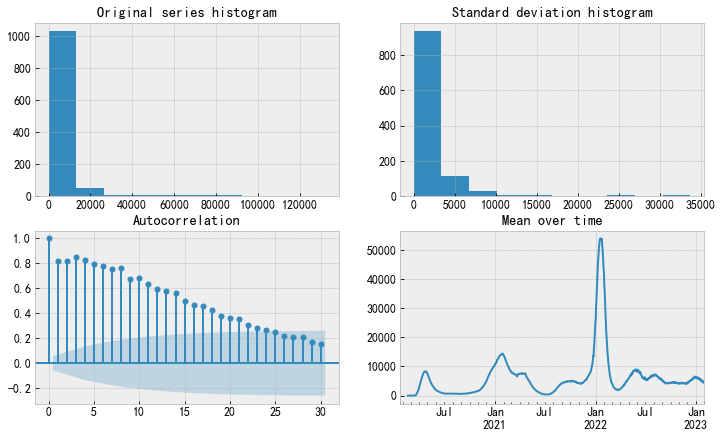

In [28]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

nyc_series.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(nyc_series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = nyc_series.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = nyc_series.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

很明显，我们的时序数据不服从高斯分布，并且自相关系数也没在蓝色阴影区间内，说名不含白噪声。

### Stationarity

> A stationary time seris means that its properties do not change with time.


#### ACF and PACF
。

> If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

> Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

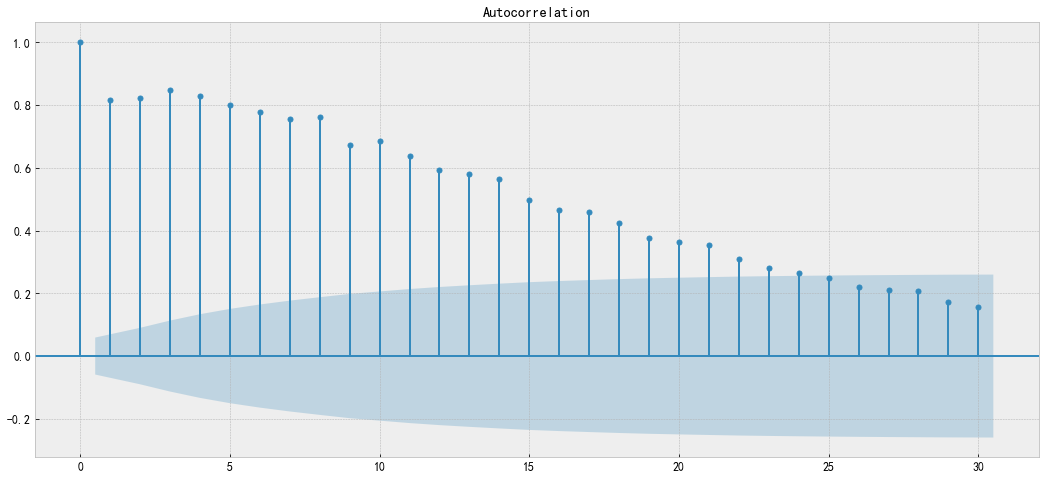

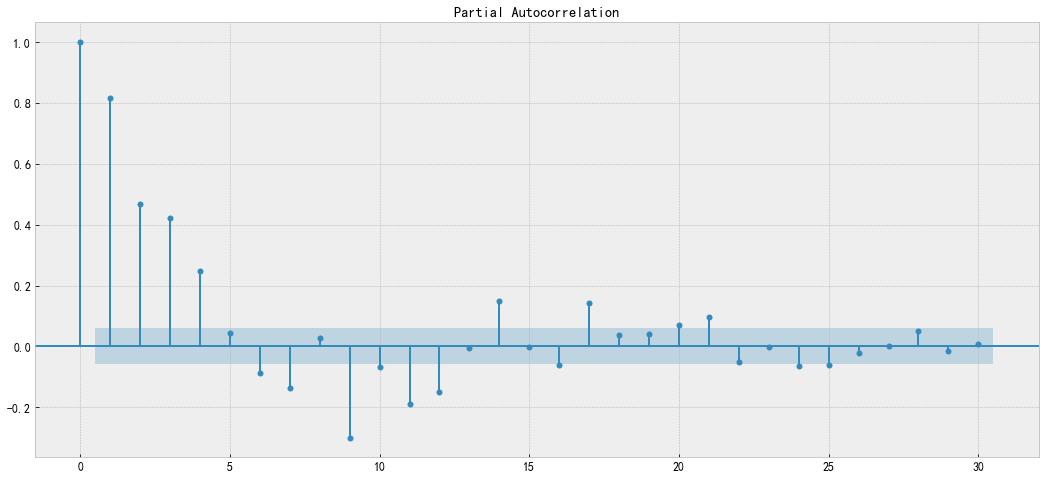

In [30]:
plot_acf(nyc_series, lags=30)
plot_pacf(nyc_series, lags=30)
plt.show()

ACF并没有很快降到0，所以不是stationary。

#### Rolling means and standard deviation

The second is to check that mean and std don't change over time, if so, it's stationary.

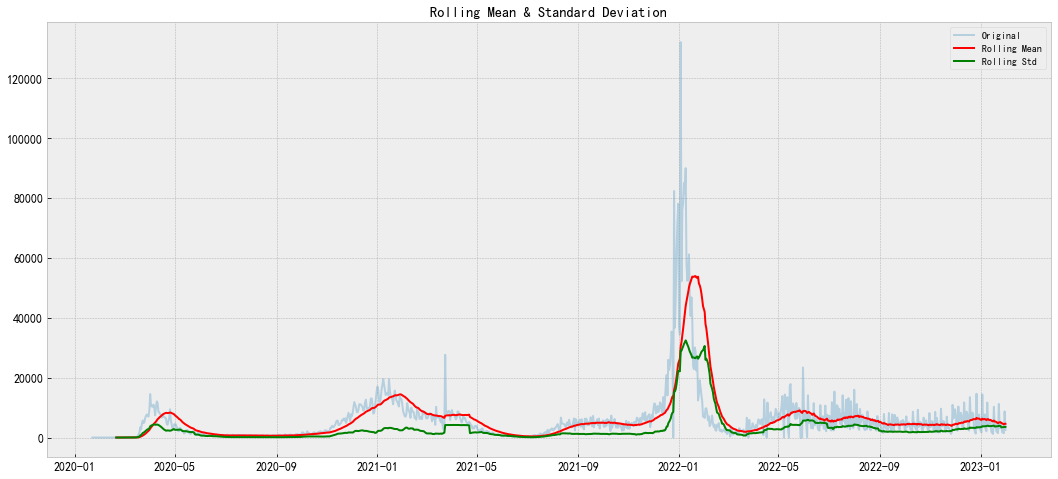

In [31]:
rolmean = nyc_series.rolling(window=30).mean()
rolstd = nyc_series.rolling(window=30).std()

# Plot rolling statistics:
orig = plt.plot(nyc_series, label='Original',alpha = .3)
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Obviously, the mean and standard deviation are not constant over time, so, this is not stationary.

In [32]:
X = nyc_series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.942596
p-value: 0.001743
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


It can be seen that p-value: 0.007040 is less than 0.05, so rejecting the null hypothesis H0 means that the sequence is stable.

ADF result：We reject H0 and the series is stationary
ADF p-value：0.001743


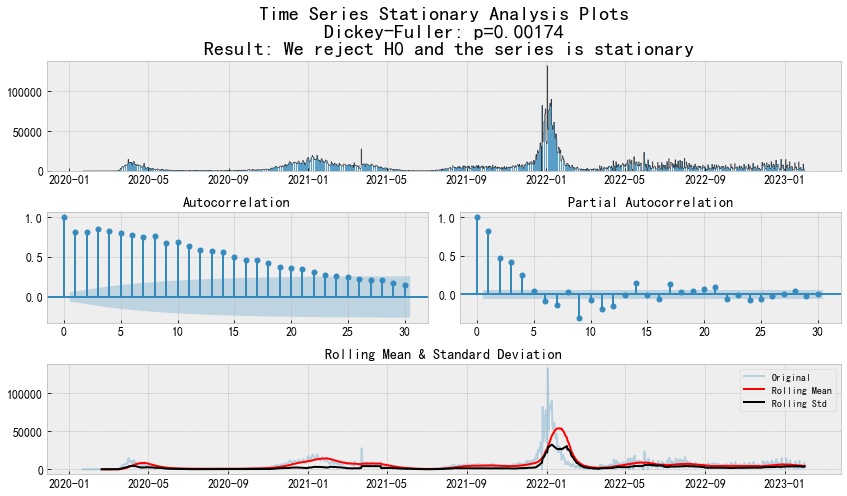

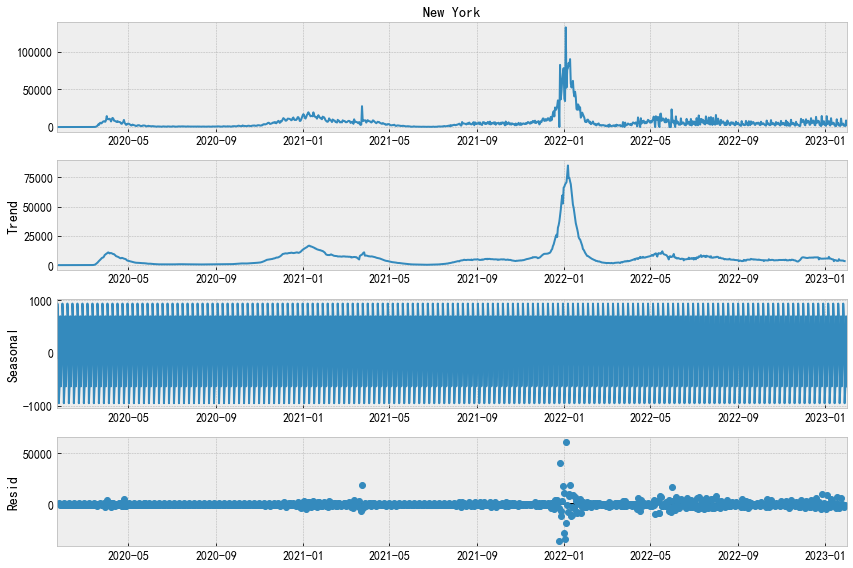

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), ma = 30, decompose = True):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        #y.plot.area(ax=ts_ax)
        ts_ax.step(y.index,y,color = '#202124',linewidth = .5)
        ts_ax.bar(y.index,y,alpha = .8)
        
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject H0 and the series is stationary" if p_value <= 0.05 else "We can not reject H0 and the series is NOT stationary"
        ts_ax.set_title(
            'Time Series Stationary Analysis Plots\n Dickey-Fuller: p={0:.5f} \n Result: {1}'.format(p_value, hypothesis_result),
        fontsize = 20)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=ma).mean()
        rolstd = y.rolling(window=ma).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original',alpha = .3)
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        print(f"ADF result：{Fore.RED}{hypothesis_result}{Style.RESET_ALL}")
        print(f"ADF p-value：{Fore.BLUE}{round(p_value,6)}{Style.RESET_ALL}")
    if decompose:
        plt.rcParams["figure.figsize"] = (12,8)
        result = seasonal_decompose(y, model='additive')
        result.plot()
        plt.show() 

tsplot(nyc_series, lags=30)